## Goodreads books file
- path
- file_name

In [27]:
path = '/media/gr00stl/81ebcc3c-eaf7-420c-9eb1-aadd739c2aaf/Goodreads/'
file_name = 'goodreads_books.json.gz'

In [28]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

## Schema

In [29]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, BooleanType, DoubleType

# Define the schema for the data
data_schema = StructType([
    StructField("isbn", StringType(), nullable=True),
    StructField("text_reviews_count", IntegerType(), nullable=True),
    StructField("series", ArrayType(StringType()), nullable=True),
    StructField("country_code", StringType(), nullable=True),
    StructField("language_code", StringType(), nullable=True),
    StructField("popular_shelves", ArrayType(
        StructType([
            StructField("count", StringType(), nullable=True),
            StructField("name", StringType(), nullable=True)
        ])
    ), nullable=True),
    StructField("asin", StringType(), nullable=True),
    StructField("is_ebook", StringType(), nullable=True),
    StructField("average_rating", DoubleType(), nullable=True),
    StructField("kindle_asin", StringType(), nullable=True),
    StructField("similar_books", ArrayType(StringType()), nullable=True),
    StructField("description", StringType(), nullable=True),
    StructField("format", StringType(), nullable=True),
    StructField("link", StringType(), nullable=True),
    StructField("authors", ArrayType(
        StructType([
            StructField("author_id", StringType(), nullable=True),
            StructField("role", StringType(), nullable=True)
        ])
    ), nullable=True),
    StructField("publisher", StringType(), nullable=True),
    StructField("num_pages", StringType(), nullable=True),
    StructField("publication_day", StringType(), nullable=True),
    StructField("isbn13", StringType(), nullable=True),
    StructField("publication_month", StringType(), nullable=True),
    StructField("edition_information", StringType(), nullable=True),
    StructField("publication_year", StringType(), nullable=True),
    StructField("url", StringType(), nullable=True),
    StructField("image_url", StringType(), nullable=True),
    StructField("book_id", StringType(), nullable=True),
    StructField("ratings_count", StringType(), nullable=True),
    StructField("work_id", StringType(), nullable=True),
    StructField("title", StringType(), nullable=True),
    StructField("title_without_series", StringType(), nullable=True)
])

In [32]:
from pyspark.sql.functions import col
import os



def create_sample_of_data(data):
    """
    Create a sample of the data and save it to parquet
    """
    # sample the data
    data_sample = data.sample(withReplacement=False, fraction=0.001, seed=42)

    # write the data to parquet
    data_sample.write.parquet(path + 'books_sample.parquet', mode='overwrite')
    return data_sample

def read_sample_of_data(schema=None):
    """
    Read the sample of the data
    """
    # read the data
    books_sample = spark.read.parquet(path + 'books_sample.parquet', schema=schema)
    return books_sample

# ----------------------------- change the schema ---------------------------- #


from pyspark.sql.types import DataType

def convert_cols(df, cols, new_type: DataType):
    for col_name in cols:
        df = df.withColumn(col_name, col(col_name).cast(new_type))
    return df

def apply_conversions(df, type_mapping):
    for data_type, columns in type_mapping.items():
        df = convert_cols(df, columns, data_type)
    return df

# Create a mapping of data types to their corresponding columns
type_mapping = {
    IntegerType(): ['text_reviews_count', 'ratings_count', 'num_pages'], 
    DoubleType(): ['average_rating'], 
    BooleanType(): ['is_ebook']
}

def create_books():
    """
    Read the data and apply the conversions
    """
    books = spark.read.json(path + file_name)
    books = apply_conversions(books, type_mapping)
    return books


def main():

    # operate on books_sample.parquet
    if 'books_sample.parquet' in os.listdir(path):
        sample = read_sample_of_data(data_schema)

    else:
        # books = spark.read.json(path + file_name)
        # books = apply_conversions(books, type_mapping)
        books = create_books()
        books.write.parquet(path + 'books.parquet', mode='overwrite')
        
        sample = create_sample_of_data(books)
        sample.write.parquet(path + 'books_sample.parquet', mode='overwrite')

    return sample

sample = main()

# print the schema
print('Schema of the sample:\n')
sample.printSchema()

# head 10
print('Head of the sample:\n')
sample.show(10)


Schema of the sample:

root
 |-- asin: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- author_id: string (nullable = true)
 |    |    |-- role: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- book_id: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- description: string (nullable = true)
 |-- edition_information: string (nullable = true)
 |-- format: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- is_ebook: boolean (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: string (nullable = true)
 |-- kindle_asin: string (nullable = true)
 |-- language_code: string (nullable = true)
 |-- link: string (nullable = true)
 |-- num_pages: integer (nullable = true)
 |-- popular_shelves: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- count: string (nullable = true)
 |    |    |-- name: string (

+----------+--------------------+--------------+--------+------------+--------------------+--------------------+---------+--------------------+--------+----------+-------------+-----------+-------------+--------------------+---------+--------------------+---------------+-----------------+----------------+--------------------+-------------+----------------+--------------------+------------------+--------------------+--------------------+--------------------+--------+
|      asin|             authors|average_rating| book_id|country_code|         description| edition_information|   format|           image_url|is_ebook|      isbn|       isbn13|kindle_asin|language_code|                link|num_pages|     popular_shelves|publication_day|publication_month|publication_year|           publisher|ratings_count|          series|       similar_books|text_reviews_count|               title|title_without_series|                 url| work_id|
+----------+--------------------+--------------+--------+-

## Data description

### Data cleaning
- outliers??
- minimum values
  - at least 20 ratings
  - at least two shelves (one is probably to-read, because its default)


## Groups

### No similar books

### Has similar books
- i know what books are similar
  - i can create ML to recreate the similar categories
  - i can create my own categories to base the similar books on
    - knn
    - xgboost?
    - voting
    - interactions


In [ ]:
# # imports
# from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, VectorAssembler
# from pyspark.ml import Pipeline
# from pyspark.ml.linalg import Vectors
# from pyspark.sql.functions import udf

# # define the pipeline
# pipeline = Pipeline(stages=[
#     CountVectorizer(inputCol="similar_books", outputCol="similar_books_vector"),
#     IDF(inputCol="similar_books_vector", outputCol="similar_books_vector_idf"),
#     Normalizer(inputCol="similar_books_vector_idf", outputCol="similar_books_vector_idf_norm")
# ])


In [ ]:
# imports for pandas profiler
from pandas_profiling import ProfileReport

In [ ]:
books_pd = sample.toPandas()
profile = ProfileReport(books_pd, title="Pandas Profiling Report", explorative=True, html={'style':{'full_width':True}})
profile.to_file(f"{path}books_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
books_with_similar_books_pd = books_pd[books_pd.similar_books.apply(lambda x: len(x) > 0)]
profile = ProfileReport(books_pd, title='books_with_similar_books Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_file(f"{path}books_with_similar_books_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Data analysis
- almost half of my sample (43%) data does not have distinct isbn -> many are scattered accross different publications??
  - not unique book
  - need to consolidate my books -> combine their values, ill provide template for that

In [ ]:
# calculate missing values

from pyspark.sql.functions import col, when, count, lit

# Initialize a list to store the results
missing_percentages = []

# List of numeric columns based on the provided schema
numeric_columns = ["text_reviews_count", "average_rating", "num_pages", "publication_year", "ratings_count", "popular_shelves.count"]

for column in numeric_columns:
    # For the nested column popular_shelves.count
    if column == "popular_shelves.count":
        missing_count = sample.where(col("popular_shelves").isNull() | 
                                    col("popular_shelves.count").isNull()).count()
    else:
        missing_count = sample.where(col(column).isNull()).count()
    
    total_count = sample.count()
    percentage_missing = (missing_count / total_count) * 100
    missing_percentages.append((column, percentage_missing))


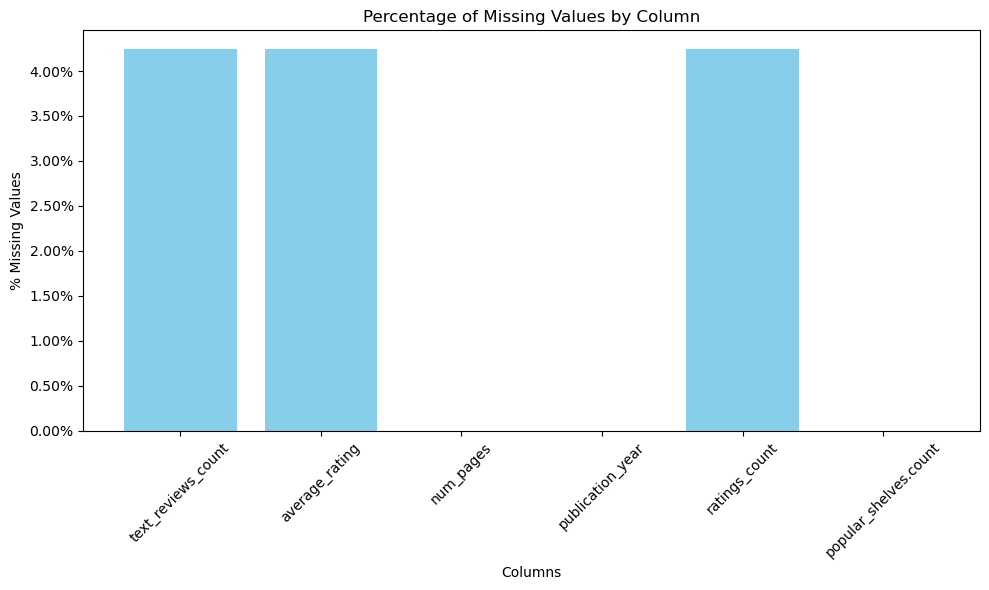

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Unzip the results into two lists
columns, percentages = zip(*missing_percentages)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(columns, percentages, color='skyblue')
plt.xlabel('Columns')
plt.ylabel('% Missing Values')
plt.title('Percentage of Missing Values by Column')
plt.xticks(rotation=45)

# Use PercentFormatter for the y-axis
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # 100 is the scale (since our values are already in percentages)
# dont show decimals


plt.tight_layout()
plt.show()


# Histograms

## histogram data

In [ ]:
# numpy
import numpy as np

## Visualisations
- one for books
- one for books with similar books

In [ ]:
# visualise histogram -> use hist, bin_edges
import matplotlib.pyplot as plt

def matplotlib_histogram(hist, bin_edges, title, xlabel, ylabel):

    # create figure
    plt.figure(figsize=(10, 6))

    # convert hist values to percentages
    hist = hist / sum(hist)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(hist)), hist, width=1, color='skyblue')
    # x axis labels -> bin edge[0]-bin edge[1], bin edge[1]-bin edge[2], ...
    # add thousands separator to x axis labels
    plt.xticks(range(len(hist)), [f'{int(bin_edges[i]):,}-{int(bin_edges[i+1]):,}' for i in range(len(hist))], rotation=45)

    # change y axis to percentage
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

    # Add title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # insert info above every bar -> percentage
    for i in range(len(hist)):
        plt.text(x=i, y=hist[i]+0.01, s=f'{hist[i]:.0%}', ha='center')

    plt.tight_layout()
    # return figure
    plt.show()

<Figure size 1000x600 with 0 Axes>

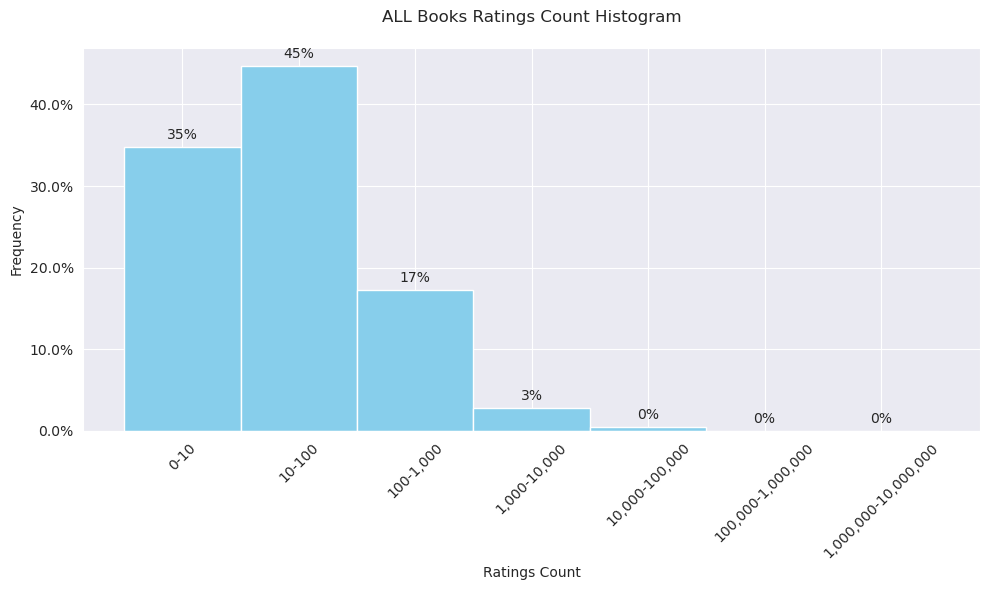

In [ ]:

data = sample.select('ratings_count').toPandas()['ratings_count']

# Define bins, e.g., bins=[0, 10, 100, 1000, 10000, ...], depending on your range and distribution
bin_edges = [0, 10, 100, 1000, 10000, 100000, 1000000, 10000000]

hist, bin_edges = np.histogram(data, bins=bin_edges)

hist, bin_edges

matplotlib_histogram(hist, bin_edges, title='ALL Books Ratings Count Histogram\n', xlabel='Ratings Count', ylabel='Frequency')

<Figure size 1000x600 with 0 Axes>

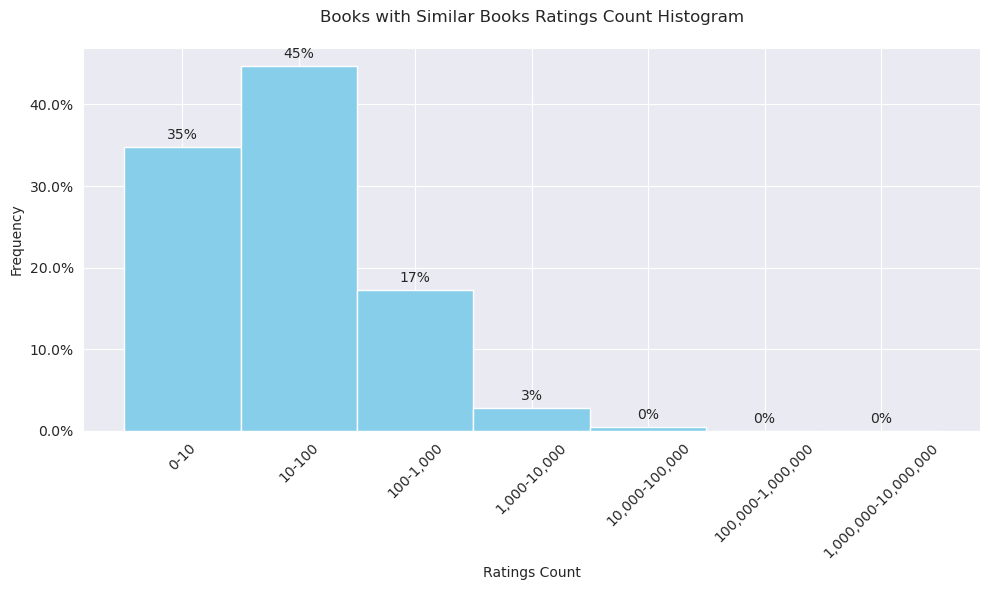

In [ ]:
# books with similar books

data = books_with_similar_books.select('ratings_count').toPandas()['ratings_count']

# Define bins, e.g., bins=[0, 10, 100, 1000, 10000, ...], depending on your range and distribution
bin_edges = [0, 10, 100, 1000, 10000, 100000, 1000000, 10000000]

hist, bin_edges = np.histogram(data, bins=bin_edges)

hist, bin_edges

matplotlib_histogram(hist, bin_edges, title='Books with Similar Books Ratings Count Histogram\n', xlabel='Ratings Count', ylabel='Frequency')

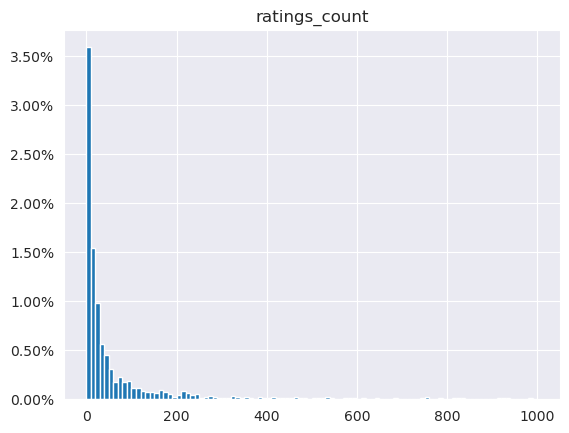

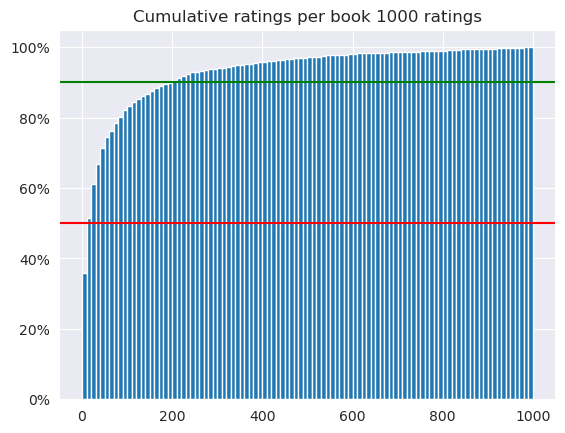

In [ ]:
# plotly go
import plotly.graph_objects as go

def create_histogram(x_values, nbins, title, x_axis_title, y_axis_title):
    """Creates a histogram using plotly go for the given x_values and nbins.

    ## Args

    - x_values (pyspark.sql.column.Column): Column of the dataframe to create the histogram for.
        - For example: books.select('ratings_count').toPandas()['ratings_count']
    
    - nbins (_type_): _description_
        - For example: 100

    - title (_type_): _description_
        - For example: 'Ratings per book'

    - x_axis_title (_type_): _description_
        - For example: 'Number of ratings'

    - y_axis_title (_type_): _description_
        - For example: 'Number of books'

    """
    
    # create histogram

    # add histogram data
    fig = go.Figure(data=[go.Histogram(x=x_values, nbinsx=nbins)])
    fig.update_layout(
        title_text=title,  # title of plot
        xaxis_title_text=x_axis_title,  # xaxis label
        yaxis_title_text=y_axis_title,  # yaxis label
        bargap=0.2,  # gap between bars of adjacent location coordinates.
        bargroupgap=0.1  # gap between bars of the same location coordinate.
    )
    
    return fig

# create histogram
fig = create_histogram(sample.select('ratings_count').toPandas()['ratings_count'], 100, 'Ratings per book', 'Number of ratings', 'Number of books').show()

# -------------------------------- matplotlib -------------------------------- #

# ratings per book -> under 1000 ratings
sample.select('ratings_count').toPandas().hist(bins=100, density=True, range=(0, 1000))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # 100 is the scale (since our values are already in percentages)

# cumulative histogram
sample.select('ratings_count').toPandas().hist(bins=100, density=True, cumulative=True, range=(0, 1000))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # 100 is the scale (since our values are already in percentages)
# change title to "cumulative ratings per book"
plt.title('Cumulative ratings per book 1000 ratings')
# add point where cumulative % is 50%
plt.axhline(y=0.5, color='r', linestyle='-')

# # --------------------------- cumulative histogram --------------------------- #

# add text with x value for y = 50%
import numpy as np

# calculate cumulative histogram
cumulative_hist, bin_edges = np.histogram(sample.select('ratings_count').toPandas()['ratings_count'], bins=100, density=True, range=(0, 1000))

x = np.where(cumulative_hist >= 0.5)[0]


# add point where cumulative % is 90%
plt.axhline(y=0.9, color='g', linestyle='-')

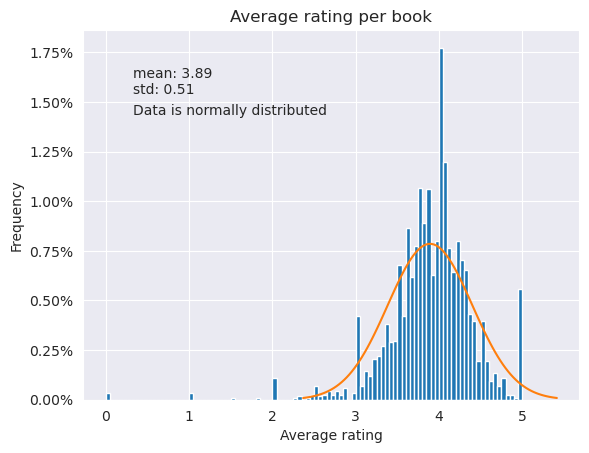

In [ ]:
# ------------------------------ average rating ------------------------------ #


# average rating per book -> % frequency
data = sample.select('average_rating').toPandas()
data.hist(bins=100, density=True, range=(0, 5))
plt.gca().yaxis.set_major_formatter(PercentFormatter(100))
# add normal distribution
import scipy.stats as stats
mu = data.mean()
sigma = data.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.title('Average rating per book')
plt.xlabel('Average rating')
plt.ylabel('Frequency')

# show stats in left upper corner -> mean, std
plt.text(x=0.1, y=0.9, s=f'mean: {mu[0]:.2f}\nstd: {sigma[0]:.2f}', ha='left', va='top', transform=plt.gca().transAxes)

# is data normally distributed?
import scipy.stats as stats
stats.normaltest(data)

# print if data is normally distributed
if stats.normaltest(data)[1] < 0.05:
    plt.text(x=0.1, y=0.8, s='Data is not normally distributed', ha='left', va='top', transform=plt.gca().transAxes)
else:
    plt.text(x=0.1, y=0.8, s='Data is normally distributed', ha='left', va='top', transform=plt.gca().transAxes)

plt.show()



## Books without similar books
- distinct group
  - what are its characteristics?

In [ ]:
books_without_similar_books = sample.filter("size(similar_books) == 0").toPandas()

In [ ]:
# report for books without similar books
profile = ProfileReport(books_without_similar_books, title='Books without similar books Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_file(f"{path}books_without_similar_books_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

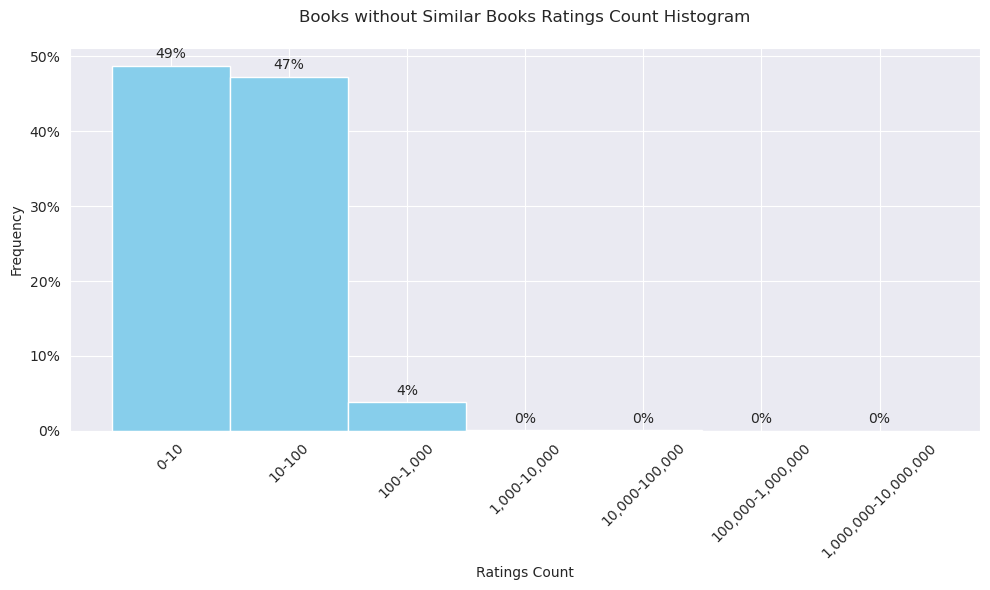

In [ ]:
# Define bins, e.g., bins=[0, 10, 100, 1000, 10000, ...], depending on your range and distribution
bin_edges = [0, 10, 100, 1000, 10000, 100000, 1000000, 10000000]

hist, bin_edges = np.histogram(books_without_similar_books['ratings_count'], bins=bin_edges)

hist, bin_edges

matplotlib_histogram(hist, bin_edges, title='Books without Similar Books Ratings Count Histogram\n', xlabel='Ratings Count', ylabel='Frequency')

## Books with similar books statistics:



Text(0.1, 0.8, 'Data is normally distributed')

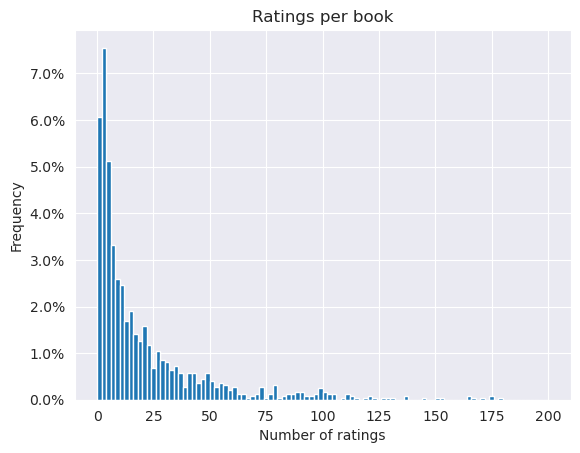

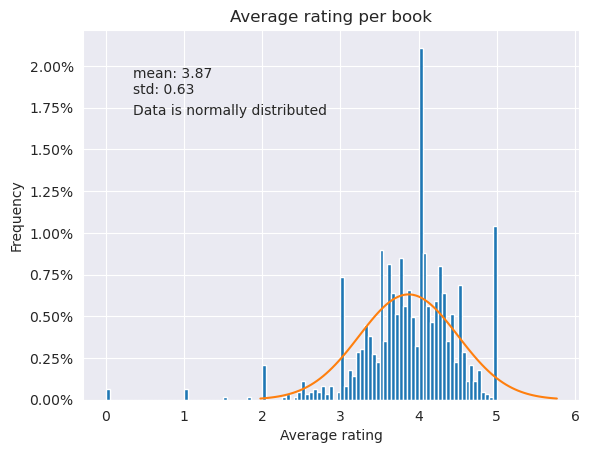

In [ ]:
# check how many books are there without any similar_books -> list empty
books_without_similar_books = sample.filter("size(similar_books) == 0").toPandas()


# statistics -> describe
print("## Books with similar books statistics:\n")
books_without_similar_books.describe()

# histogram -> ratings_count
books_without_similar_books.hist(column='ratings_count', bins=100, density=True, range=(0, 200))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # 100 is the scale (since our values are already in percentages)
plt.title('Ratings per book')
plt.xlabel('Number of ratings')
plt.ylabel('Frequency')

# histogram -> average_rating
books_without_similar_books.hist(column='average_rating', bins=100, density=True, range=(0, 5))
plt.gca().yaxis.set_major_formatter(PercentFormatter(100))
plt.title('Average rating per book')
plt.xlabel('Average rating')
plt.ylabel('Frequency')

# add normal distribution
import scipy.stats as stats
mu = books_without_similar_books['average_rating'].mean()
sigma = books_without_similar_books['average_rating'].std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.title('Average rating per book')
plt.xlabel('Average rating')
plt.ylabel('Frequency')

# show stats in left upper corner -> mean, std
plt.text(x=0.1, y=0.9, s=f'mean: {mu:.2f}\nstd: {sigma:.2f}', ha='left', va='top', transform=plt.gca().transAxes)
plt.text(
    x=0.1, 
    y=0.8, 
    s='Data is not normally distributed' if stats.normaltest(books_without_similar_books['average_rating'])[1] < 0.05 else 'Data is normally distributed',
    ha='left', 
    va='top', 
    transform=plt.gca().transAxes
)



In [ ]:
# use .describe() to get a summary of the data for every column

# measure performance time
import time
start_time = time.time()

# List of numeric columns based on the provided schema
numeric_columns = ["text_reviews_count", "average_rating", "num_pages", "publication_year", "ratings_count", "popular_shelves.count"]

# plot missing values for all columns on heatmap
import plotly.graph_objects as go

# get missing values for all columns
from pyspark.sql.functions import isnan, when, count, col
# select numeric_columns only
missing_values = books_with_similar_books.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_columns]).toPandas().to_dict()



# # minimum values subset
# ## at least 20 ratings
# cleaned_df = cleaned_df.filter("ratings_count >= 20")

# ## at least two popular_shelves
# cleaned_df = cleaned_df.filter("size(popular_shelves) >= 2")

# # Now you can describe the cleaned DataFrame
# stats = cleaned_df.describe(numeric_columns)
# stats.show()

# # measure performance time
# end_time = time.time()

# print("Total execution time: {}".format(end_time - start_time))

# Scatterplot
- what relationships may occur,
- which data to choose for recommendations?
  - num_pages -> ratings (count, average)
  - shelves (favorited, but only those that describe a genre -> skip redundant ones like to-read)
    - similar count
    - similar shelves

In [ ]:
# create scatterplot matrix
import pandas as pd
import seaborn as sns

# convert spark dataframe to pandas dataframe

# create scatterplot matrix, use plotly.graph_objects
import plotly.graph_objects as go

# trace
trace = go.Scatter(
    x = books_with_similar_books_pd['ratings_count'],
    y = books_with_similar_books_pd['average_rating'],
    mode = 'markers'
)

# layout
fig = go.Figure(data=[trace])
fig.show()
